- https://keras.io/examples/timeseries/timeseries_traffic_forecasting/#graph-convolution-layer
- https://towardsdatascience.com/time-series-forecasting-with-graph-convolutional-neural-network-7ffb3b70afcf

In [26]:
%load_ext autoreload
%autoreload 2

import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

from utils.base_helpers import read_data, split_data, scale_data, expand_data, plot_metrics
from utils.graph_helpers import generate_adj_matrix, create_graph, LSTMGC, calculate_wmape_tf as wmape
from utils.tf_helpers import WindowGenerator, compile_and_fit, plot_plantwise_predictions

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import typing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df, plants = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=8)
train_df_, valid_df, test_df = split_data(df, train_ratio=0.8, valid_ratio=0.1)
train_df, valid_df, test_df = expand_data(train_df_, valid_df, test_df)
train_df, valid_df, test_df = scale_data(train_df, valid_df, test_df, plants, scaler="minmax")

Train start and end dates:	 2019-01-26 03:00:00 	 2021-06-22 09:00:00
Validation start and end dates:	 2021-06-22 10:00:00 	 2021-10-10 04:00:00
Test start and end dates:	 2021-10-10 05:00:00 	 2022-01-27 23:00:00


In [11]:
OUT_STEPS = 24
INPUT_WIDTH = 30

window = WindowGenerator(
    train_df=train_df, valid_df=valid_df, test_df=test_df, 
    columns=[col for col in df.columns if col != "rt_plant_id"],
    input_width=INPUT_WIDTH, label_width=OUT_STEPS, shift=0, label_columns=["production"])
window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['production']

In [12]:
adjacency_matrix = generate_adj_matrix(train_df_, threshold=0.6)
graph = create_graph(adjacency_matrix)

number of nodes: 8, number of edges: 60


In [13]:
epochs = 20
OUT_FEAT = 64
lstm_units = 32
BATCH_SIZE = 64

NUM_NODES = window.number_of_plants
IN_FEAT = len(window.feature_column_indices)
INPUT_SEQ_LEN = INPUT_WIDTH
forecast_horizon = OUT_STEPS
multi_horizon = True

graph_conv_params = {
    "aggregation_type": "mean", # sum, max
    "combination_type": "concat", # add
    "activation": None,
}
keras_params = {
    "lstm_activation": "tanh",
    "dense_activation": "sigmoid"
}

st_gcn = LSTMGC(IN_FEAT, OUT_FEAT, lstm_units, INPUT_SEQ_LEN, 
    forecast_horizon, graph, graph_conv_params, keras_params)
inputs = layers.Input((INPUT_SEQ_LEN, graph.num_nodes, IN_FEAT))
outputs = st_gcn(inputs)

model = models.Model(inputs, outputs)


In [14]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0002),loss="mse", metrics=["mse", wmape],)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 8, 17)]       0         
                                                                 
 lstmgc_1 (LSTMGC)           (None, 24, 8)             22488     
                                                                 
Total params: 22,488
Trainable params: 22,488
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(window.train, validation_data=window.valid, epochs=epochs, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]) # , WandbCallback()])

In [15]:
param_dict = {"loss": "mse", "optimizer": "rmsprop"}

In [16]:
model, history = compile_and_fit(model, window, max_epochs=10, verbose=1, **param_dict)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.0480 - wmape: 0.4737
Epoch 1: val_wmape improved from inf to 0.33434, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 14s 39ms/step - loss: 0.0480 - wmape: 0.4737 - val_loss: 0.0355 - val_wmape: 0.3343
Epoch 2/10
328/329 [============================>.] - ETA: 0s - loss: 0.0332 - wmape: 0.3731
Epoch 2: val_wmape improved from 0.33434 to 0.29575, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 12s 38ms/step - loss: 0.0332 - wmape: 0.3730 - val_loss: 0.0299 - val_wmape: 0.2958
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.0296 - wmape: 0.3474
Epoch 3: val_wmape improved from 0.29575 to 0.29030, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 13s 39ms/step - loss: 0.0296 - wmape: 0.3474 - val_loss: 0.0297 - val_wmape: 0.2

In [22]:
val_performance = {}
performance = {}

param_list = [
    {"loss": "mse", "optimizer": "rmsprop"},
    {"loss": "mse", "optimizer": "adam"},
    {"loss": "binary_crossentropy", "optimizer": "rmsprop"},
    {"loss": "binary_crossentropy", "optimizer": "adam"},
]

for param_dict in param_list:
    model, history = compile_and_fit(model, window, max_epochs=10, verbose=2, **param_dict)
    val_performance["-".join(param_dict.values())] = model.evaluate(window.valid)
    performance["-".join(param_dict.values())] = model.evaluate(window.test)


Epoch 1/10

Epoch 1: val_wmape improved from inf to 0.25666, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 - 13s - loss: 0.0224 - wmape: 0.2942 - val_loss: 0.0243 - val_wmape: 0.2567 - 13s/epoch - 39ms/step
Epoch 2/10

Epoch 2: val_wmape improved from 0.25666 to 0.25212, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 - 11s - loss: 0.0218 - wmape: 0.2897 - val_loss: 0.0242 - val_wmape: 0.2521 - 11s/epoch - 34ms/step
Epoch 3/10

Epoch 3: val_wmape did not improve from 0.25212
329/329 - 11s - loss: 0.0214 - wmape: 0.2861 - val_loss: 0.0247 - val_wmape: 0.2582 - 11s/epoch - 34ms/step
Epoch 4/10

Epoch 4: val_wmape did not improve from 0.25212
329/329 - 11s - loss: 0.0210 - wmape: 0.2829 - val_loss: 0.0241 - val_wmape: 0.2552 - 11s/epoch - 35ms/step
Epoch 5/10

Epoch 5: val_wmape improved from 0.25212 to 0.25049, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 - 11s - loss: 0.0206 - wmape: 0.2804 - val_loss: 0.0240 - va

In [23]:
val_performance

{'mse-rmsprop': [0.023771433159708977, 0.2501632571220398],
 'mse-adam': [0.02239510975778103, 0.24308449029922485],
 'binary_crossentropy-rmsprop': [0.47216397523880005, 0.243602454662323],
 'binary_crossentropy-adam': [0.4695650041103363, 0.23780164122581482]}

In [24]:
performance

{'mse-rmsprop': [0.028932960703969002, 0.2863962650299072],
 'mse-adam': [0.02889716438949108, 0.28368452191352844],
 'binary_crossentropy-rmsprop': [0.4557470679283142, 0.27987033128738403],
 'binary_crossentropy-adam': [0.45821577310562134, 0.2805081009864807]}

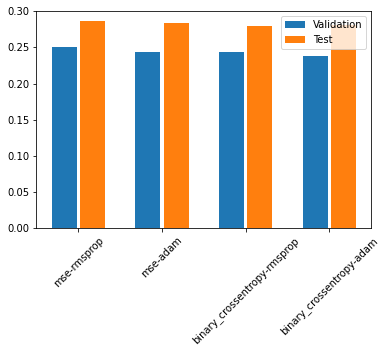

In [27]:
plot_metrics(performance, val_performance)

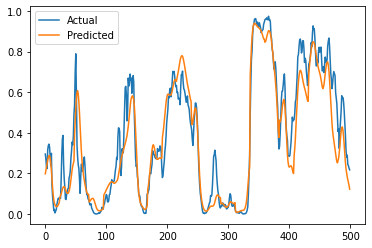

In [28]:
plot_plantwise_predictions(model, window.test)

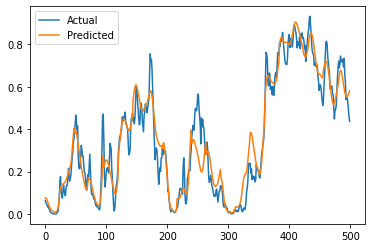

In [31]:
plot_plantwise_predictions(model, window.valid)

In [ ]:
import wandb
from wandb.keras import WandbCallback

# wandb.init(project="graph", entity="merts")

wandb.config = {
  "in_feat": 17,
  "epochs": 50,
  "batch_size": 64,
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

In [ ]:
NUM_NODES=df.rt_plant_id.nunique()
IN_FEAT = 17
BATCH_SIZE = 64
epochs = 1
INPUT_SEQ_LEN = 48
forecast_horizon = 24
multi_horizon = True
OUT_FEAT = 128
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean", # sum, max
    "combination_type": "concat", # add
    "activation": None,
}

def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape


st_gcn = LSTMGC(
    IN_FEAT,
    OUT_FEAT,
    lstm_units,
    INPUT_SEQ_LEN,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((INPUT_SEQ_LEN, graph.num_nodes, IN_FEAT))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),loss="mse", metrics=["mse", wmape],)
print(model.summary())
model.fit(window.train, validation_data=window.valid, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # , WandbCallback()])

In [ ]:
test_df.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_test, y = next(window.test.as_numpy_iterator())
y_pred = model.predict(x_test)

plt.figure(figsize=(18, 6))
plant_id = 9

plt.plot(y[:, :, plant_id, 0].flatten())
plt.plot(y_pred[:, :, plant_id].flatten())
plt.legend(["actual", "forecast"])

In [ ]:
from utils.tf_helpers import calculate_plantwise_wmape

In [ ]:
calculate_plantwise_wmape(model, window, plants)

In [ ]:
inp_seq = Input((sequence_length, 10))
inp_lap = Input((10, 10))
inp_feat = Input((10, X_train_feat.shape[-1]))
x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
x = GraphConv(16, activation='relu')([x, inp_lap])
x = Flatten()(x)
xx = LSTM(128, activation='relu',return_sequences=True)(inp_seq)
xx = LSTM(32, activation='relu')(xx)
x = Concatenate()([x,xx])
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1)(x)
model = Model([inp_seq, inp_lap, inp_feat], out)